# Virus spread

This code is developed by Joël Foramitti and taken from https://agentpy.readthedocs.io/en/latest/agentpy_virus_spread.html

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [ ]:
!pip install agentpy

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

In [2]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        
    def being_sick(self):
        """ Spread disease to peers in the network. """
        rng = self.model.random
        for n in self.network.neighbors(self): 
            if n.condition == 0 and self.p.infection_chance > rng.random():
                n.condition = 1  # Infect susceptible peer
        if self.p.recovery_chance > rng.random(): 
            self.condition = 2  # Recover from infection

In [3]:
class VirusModel(ap.Model):
    
    def setup(self):
        """ Initialize the agents and network of the model. """
        
        # Prepare a small-world network
        graph = nx.watts_strogatz_graph(
            self.p.population, 
            self.p.number_of_neighbors, 
            self.p.network_randomness)
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.population, Person)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)
        
        # Infect a random share of the population
        I0 = int(self.p.initial_infection_share * self.p.population)
        self.agents.random(I0).condition = 1 

    def update(self):  
        """ Record variables after setup and each step. """
        
        # Record share of agents with each condition
        for i, c in enumerate(('S', 'I', 'R')):
            n_agents = len(self.agents.select(self.agents.condition == i))
            self[c] = n_agents / self.p.population 
            self.record(c)
        
        # Stop simulation if disease is gone
        if self.I == 0:
            self.stop()
        
    def step(self):   
        """ Define the models' events per simulation step. """
        
        # Call 'being_sick' for infected agents
        self.agents.select(self.agents.condition == 1).being_sick()
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
        
        # Record final evaluation measures
        self.report('Total share infected', self.I + self.R) 
        self.report('Peak share infected', max(self.log['I']))

## Running a simulation

In [4]:
parameters = {  
    'population': 1000,
    'infection_chance': 0.3,
    'recovery_chance': 0.1,
    'initial_infection_share': 0.1,
    'number_of_neighbors': 2,
    'network_randomness': 0.5   
}

model = VirusModel(parameters)
results = model.run() 

Completed: 97 steps
Run time: 0:00:00.433272
Simulation finished


## Analyzing results

In [6]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 6 keys
'variables': 
    'VirusModel': DataFrame with 3 variables and 98 rows
'reporters': DataFrame with 2 variables and 1 row
}

In [7]:
results.variables.VirusModel.head()

S      I      R
t                     
0  0.900  0.100  0.000
1  0.843  0.148  0.009
2  0.786  0.189  0.025
3  0.734  0.223  0.043
4  0.685  0.251  0.064

In [9]:
results.reporters

Total share infected  Peak share infected
0                 0.664                0.294

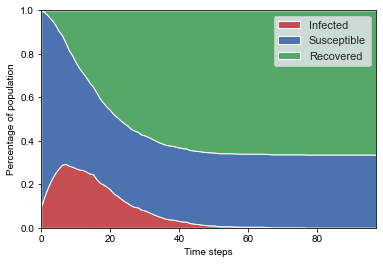

In [10]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]
    
    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
                 colors = ['r', 'b', 'g'])    
    
    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

fig, ax = plt.subplots()
virus_stackplot(results.variables.VirusModel, ax)

## Creating an animation

In [7]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")
    
    # Plot stackplot on first axis
    virus_stackplot(m.output.variables.VirusModel, ax1)
    
    # Plot network on second axis
    color_dict = {0:'b', 1:'r', 2:'g'}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.network.graph, node_color=colors, 
                     node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure 
parameters['population'] = 50 # Lower population for better visibility 
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

Using Jupyter, we can display this animation directly in our notebook.

In [8]:
IPython.display.HTML(animation.to_jshtml()) 

## Multi-run experiment

In [26]:
parameters = {
    'population': ap.IntRange(100, 1000),
    'infection_chance': ap.Range(0.1, 1.),
    'recovery_chance': ap.Range(0.1, 1.),
    'initial_infection_share': 0.1,
    'number_of_neighbors': 2,
    'network_randomness': ap.Range(0., 1.)
}

sample = ap.Sample(
    parameters, 
    n=12,
    #n=128,
    #method='linspace', 
    method='saltelli', 
    #calc_second_order=False
)

In [27]:
exp = ap.Experiment(VirusModel, sample, iterations=10)
results = exp.run()

Scheduled runs: 300
Completed: 300, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:28.319028


Optionally, we can save and load our results as follows:

In [14]:
results.save()

Data saved to ap_output/VirusModel_2


In [15]:
results = ap.DataDict.load('VirusModel')

Loading from directory ap_output/VirusModel_2/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


In [28]:
results

DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'sample': DataFrame with 4 variables and 30 rows
    'log': Dictionary with 5 keys
'reporters': DataFrame with 2 variables and 300 rows
}

In [30]:
results.parameters.sample

population  infection_chance  recovery_chance  network_randomness
sample_id                                                                   
0                 297          0.187012         0.566699            0.676758
1                 352          0.187012         0.566699            0.676758
2                 297          0.916504         0.566699            0.676758
3                 297          0.187012         0.141309            0.676758
4                 297          0.187012         0.566699            0.899414
5                 297          0.916504         0.141309            0.899414
6                 352          0.187012         0.141309            0.899414
7                 352          0.916504         0.566699            0.899414
8                 352          0.916504         0.141309            0.676758
9                 352          0.916504         0.141309            0.899414
10                748          0.637012         0.116699            0.176758
11                803          0.637012         0.116699            0.176758
12                748          0.466504         0.116699            0.176758
13                748          0.637012         0.591309            0.176758
14                748          0.637012         0.116699            0.399414
15                748          0.466504         0.591309            0.399414
16                803          0.637012         0.591309            0.399414
17                803          0.466504         0.116699            0.399414
18                803          0.466504         0.591309            0.176758
19                803          0.466504         0.591309            0.399414
20                973          0.412012         0.791699            0.926758
21                577          0.412012         0.791699            0.926758
22                973          0.241504         0.791699            0.926758
23                973          0.412012         0.366309            0.926758
24                973          0.412012         0.791699            0.149414
25                973          0.241504         0.366309            0.149414
26                577          0.412012         0.366309            0.149414
27                577          0.241504         0.791699            0.149414
28                577          0.241504         0.366309            0.926758
29                577          0.241504         0.366309            0.149414

In [29]:
results.reporters

Total share infected  Peak share infected
sample_id iteration                                           
0         0                      0.208754             0.097643
          1                      0.171717             0.097643
          2                      0.178451             0.097643
          3                      0.151515             0.097643
          4                      0.191919             0.097643
...                                   ...                  ...
29        5                      0.214905             0.102253
          6                      0.228769             0.100520
          7                      0.244367             0.114385
          8                      0.249567             0.110919
          9                      0.265165             0.112652

[300 rows x 2 columns]

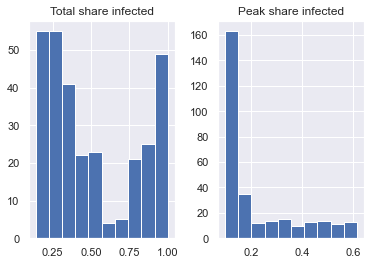

In [31]:
results.reporters.hist();

## Sensitivity analysis

In [32]:
results.calc_sobol()

DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'sample': DataFrame with 4 variables and 30 rows
    'log': Dictionary with 5 keys
'reporters': DataFrame with 2 variables and 300 rows
'sensitivity': 
    'sobol': DataFrame with 6 variables and 8 rows
    'sobol_conf': DataFrame with 6 variables and 8 rows
}

In [34]:
results.sensitivity.sobol_conf

order                                            S1         ST         S2  \
parameter                                                      population   
reporter             parameter                                              
Total share infected population            3.537760   0.076243        NaN   
                     infection_chance     28.028225   4.679831        NaN   
                     recovery_chance      51.222570  15.673548        NaN   
                     network_randomness   10.465879   0.663561        NaN   
Peak share infected  population           11.080030   0.205935        NaN   
                     infection_chance      0.588206   0.100933        NaN   
                     recovery_chance     143.364036  34.250996        NaN   
                     network_randomness    0.821924   0.029353        NaN   

order                                                                     \
parameter                               infection_chance recovery_chance   
reporter             parameter                                             
Total share infected population                 3.692549        2.122326   
                     infection_chance                NaN       40.420068   
                     recovery_chance                 NaN             NaN   
                     network_randomness              NaN             NaN   
Peak share infected  population                 8.641794        9.749715   
                     infection_chance                NaN       69.023249   
                     recovery_chance                 NaN             NaN   
                     network_randomness              NaN             NaN   

order                                                       
parameter                               network_randomness  
reporter             parameter                              
Total share infected population                   2.372495  
                     infection_chance            79.914359  
                     recovery_chance             69.950874  
                     network_randomness                NaN  
Peak share infected  population                   8.664023  
                     infection_chance           125.033080  
                     recovery_chance            167.500209  
                     network_randomness                NaN

C:\Users\steph\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


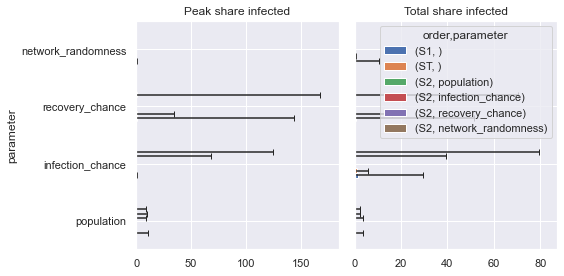

In [35]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by='reporter')
    si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel('reporter')
        err = err.droplevel('reporter')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)
    
    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[]) 
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

Alternatively, we can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

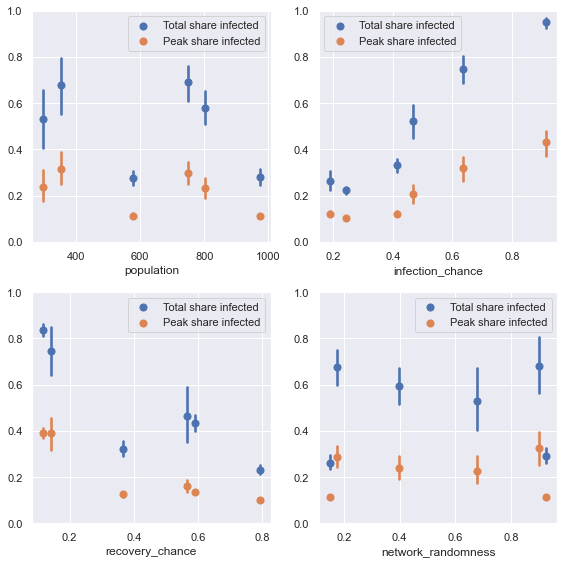

In [36]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_reporters() 
    params = results.parameters.sample.keys() 
    
    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0,1)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)